In [213]:
import kagglehub
rowhitswami_stopwords_path = kagglehub.dataset_download('rowhitswami/stopwords')
suchintikasarkar_sentiment_analysis_for_mental_health_path = kagglehub.dataset_download('suchintikasarkar/sentiment-analysis-for-mental-health')

print('Data source import complete.')


Data source import complete.


# **1. Import Libraries**

In [214]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mp

import seaborn as sns
sns.set_style('darkgrid')

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from wordcloud import WordCloud

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from tqdm.notebook import tqdm; tqdm.pandas();

In [215]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [216]:
with open('/content/stopwords.txt','r') as file:
    stop_words = [row.strip() for row in file]

# **2. Import Data**

In [217]:
df = pd.read_csv('/content/Combined Data.csv',index_col = 'Unnamed: 0')
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


# **3. Exploration Data Analysis**

## 3.1 General Information

In [218]:
df.shape

(53043, 2)

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [220]:
df.isnull().sum()

,0
statement,362
status,0


In [221]:
df[df.statement.isnull()] # Chech where the values are Null

,statement,status
293,NaN,Anxiety
572,NaN,Anxiety
595,NaN,Anxiety
1539,NaN,Normal
2448,NaN,Normal
...,...,...
52838,NaN,Anxiety
52870,NaN,Anxiety
52936,NaN,Anxiety
53010,NaN,Anxiety


## 3.2 Clean Null Rows

In [222]:
df = df[~df.statement.isna()] # Delete all rows with Null values

In [223]:
df.reset_index(drop = True, inplace = True)

In [224]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
52676,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
52677,"selfishness ""I don't feel very good, it's lik...",Anxiety
52678,Is there any way to sleep better? I can't slee...,Anxiety
52679,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [225]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


## 3.3 Plot of Mental Types

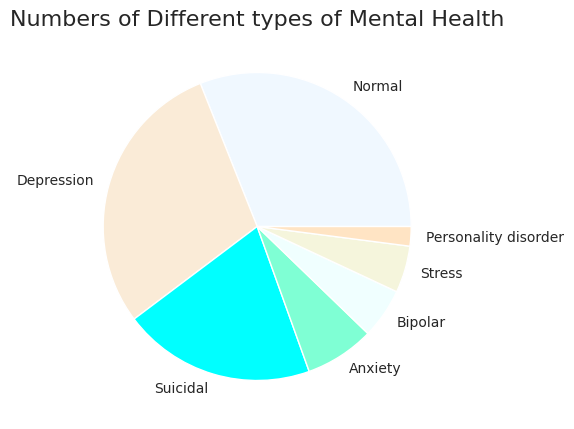

In [226]:
fig, ax = plt.subplots(figsize = (5,5))

random_colors = [color for name,color in mp.colors.cnames.items()]
ax.pie(x = df.status.value_counts(),
       labels = df.status.value_counts().index,
       colors =random_colors,
    )
ax.set_title('Numbers of Different types of Mental Health', fontdict={'fontsize':16})

plt.show()

# **4. Preprocessing**

In [227]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])
for status,statement in random_statements.items():
    print(f'Status: {status}')
    print(f'Statement: {statement}')
    print('-'*79)

Status: Anxiety
Statement: Are my symptoms a result of anxiety or is my anxiety a result of symptoms of something that’s killing me? It’s safe to say I live my life with nearly constant anxiety, particularly when it comes to my health. I’m hyper aware of sensations and little pains that come and go in my body at any given time. My life is kind of miserable as a result. In the quiet moments during a conversation I can almost guarantee you that’s what I’m thinking about. Whether or not the pain I just felt in my head or torso is a symptom of anxiety or do I have some sort of cancer that’s eating me alive?Am I alone in this or am I just a crazy person? I hate to sound whiny, just thought I’d vent a bit. 
-------------------------------------------------------------------------------
Status: Bipolar
Statement: Mentioning disability on job application? I've been out from work for 7 months on disability related to my bipolar diagnosis. My current workplace is terrible and I'm not looking for

In [228]:
def preprocess(text, lemmatize = False, stem = False):
    text = text.replace('\n', ' ').replace('\r', ' ').strip()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text.lower())
    pattern = re.compile(r"[a-z-A-Z-0-9]+")

    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    tokens = [word for word in tokens if pattern.fullmatch(word) and word not in stop_words and len(word) > 1]
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [229]:
df['preprocessed'] = df.statement.progress_apply(preprocess)

  0%|          | 0/52681 [00:00<?, ?it/s]

In [230]:
random_value = np.random.randint(0,df.shape[0])
print("Status:",df['status'].iloc[random_value])
print("Preprocessed Tokens:",df['preprocessed'].iloc[random_value])

Status: Bipolar
Preprocessed Tokens: ['voluntary', 'involuntary', 'admission', 'read', 'posts', 'talked', 'doctor', 'told', 'admitted', 'involuntary', 'voluntarily', 'change', 'involuntary', 'hospital', 'whenever', 'gone', 'er', 'willingly', 'moment', 'er', 'doctor', 'interviews', 'immediately', 'formed', 'willing', 'stay', 'voluntarily', 'admitted', 'involuntary', 'patient', 'else', 'convince', 'admit', 'voluntarily']


## 4.1 Most Frequent and Rare Values

In [231]:
from collections import Counter
cnt = Counter()
for text in df["preprocessed"].values:
    for word in text:
        cnt[word] += 1

In [232]:
n_words = 20
FREQWORDS = set([w for (w, wc) in cnt.most_common(n_words)])
print(FREQWORDS)

{'bad', 'help', 'family', 'live', 'friends', 'don', 'anxiety', 'life', 'time', 'getting', 'day', 'hate', 'am', 'feel', 'anymore', 'fucking', 'feeling', 'job', 'people', 'depression'}


In [233]:
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_words-1:-1]])
print(RAREWORDS)

{'comfused', 'cokeheads', 'antideps', 'confuaed', 'chrisis', 'upkeeps', 'thoughta', 'bloat', 'stroke-like', 'father-daughter', 'itnto', 'precribed', 'amoking', 'attack-like', 'ancillary', 'coprophobia', 'tingeling', 'propositions', 'turnovers', 'sided-friendship'}


## 4.2 WordCloud

In [234]:
tokens_data = ' '.join([' '.join(item) for item in df.preprocessed.values])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens_data)

## 4.3 Prepare Data

In [235]:
df.head()

,statement,status,preprocessed
0,oh my gosh,Anxiety,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"[wrong, dear, forward, doubt, stay, restless, ..."
3,I've shifted my focus to something else but I'...,Anxiety,"[shifted, focus, else, worried]"
4,"I'm restless and restless, it's been a month n...",Anxiety,"[restless, restless, month, boy, mean]"


In [236]:
df['status'].values

array(['Anxiety', 'Anxiety', 'Anxiety', ..., 'Anxiety', 'Anxiety',
       'Anxiety'], dtype=object)

In [237]:
encoder = LabelEncoder()
labels = encoder.fit_transform(df['status'].values)
labels

array([0, 0, 0, ..., 0, 0, 0])

In [238]:
X = df['preprocessed'].values
print(X[:5])

[list(['oh', 'gosh'])
 list(['trouble', 'sleeping', 'confused', 'mind', 'restless', 'heart', 'tune'])
 list(['wrong', 'dear', 'forward', 'doubt', 'stay', 'restless', 'restless'])
 list(['shifted', 'focus', 'else', 'worried'])
 list(['restless', 'restless', 'month', 'boy', 'mean'])]


In [239]:
X.shape

(52681,)

In [240]:
labels.shape

(52681,)

## 4.4 Split Data into Train and Test Sets

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = 42)

## 4.5 Convert Features using TF-IDF

In [242]:
vectorizer = TfidfVectorizer(max_features=50000, ngram_range= (1,2))
X_train_tfidf = vectorizer.fit_transform([' '.join(i) for i in X_train])
X_test_tfidf = vectorizer.transform([' '.join(i) for i in X_test])

# **5. Finding and Training the best Model**

In [243]:
models = {
"Logistic Regression":LogisticRegression(C = 10, max_iter=100),
"Random Forest":RandomForestClassifier(n_estimators=100),
"Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5),
"XGBoost": XGBClassifier(n_estimators=100,learning_rate =0.1, max_depth=5)
}

In [244]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=70, max_depth = 50, n_jobs = -1)

rf_model.fit(X_train_tfidf, y_train)

predicted_y_rf = rf_model.predict(X_test_tfidf)

results = {
    'RandomForest': {
        'model': rf_model,
        'score': accuracy_score(y_test, predicted_y_rf),
    }
}

print("Random Forest")
print(results['RandomForest'])
print('-' * 100)


Random Forest
{'model': RandomForestClassifier(max_depth=50, n_estimators=70, n_jobs=-1), 'score': 0.6372781626648951}
----------------------------------------------------------------------------------------------------


In [245]:
import joblib

joblib.dump(rf_model, 'random_forest_model.joblib')

rf_model_loaded = joblib.load('random_forest_model.joblib')

## 5.1 Build Confustion Matrixes

In [246]:
def print_confusion_matrix(y_test,model):

    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    con = confusion_matrix(y_true=y_test, y_pred=y_pred)
    labels = encoder.classes_
    ax = sns.heatmap(con, annot = True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    ax.set_title(f'{type(model).__name__} - {acc:.2}%')
    plt.show()

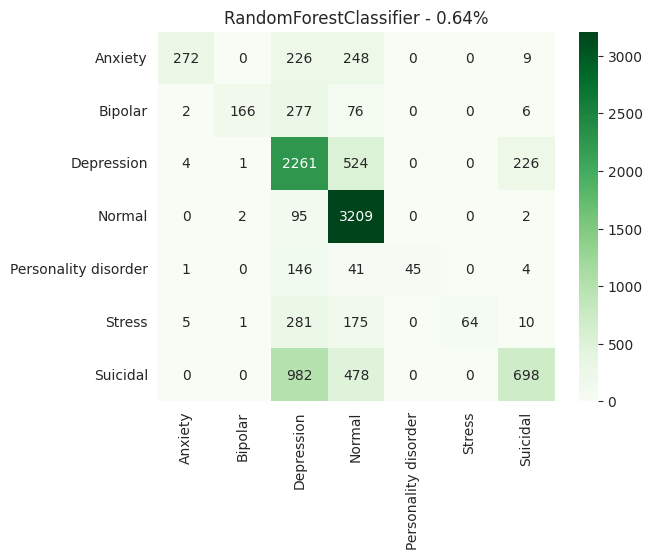

In [247]:
for model_name in results:
    model = results[model_name]['model']
    print_confusion_matrix(y_test,model)

### **Predictions**

In [249]:
import scipy.sparse as sp
import numpy as np

def predict_sentiment(text):

    sample_text_transformed = vectorizer.transform([text])


    input_data = sp.lil_matrix((1, rf_model.n_features_in_))
    input_data[0, :sample_text_transformed.shape[1]] = sample_text_transformed.toarray()
    input_data = input_data.tocsr()

    predicted_class = rf_model.predict(input_data)[0]

    original_label = encoder.inverse_transform([predicted_class])[0]
    sentiment_score = sentiment_mapping.get(original_label, 0)  # Default to 0 if not found

    print(f"Sample Text: {text}")
    print(f"Predicted Label: {original_label}")
    print(f"Sentiment Score: {sentiment_score}")
    return sentiment_score

print("Sentiment for 'I am feeling relaxed':", predict_sentiment("I am feeling relaxed"))
print("Sentiment for 'I am feeling depressed':", predict_sentiment("I am feeling depressed"))


Sample Text: I am feeling relaxed
Predicted Label: Normal
Sentiment Score: 1
Sentiment for 'I am feeling relaxed': 1
Sample Text: I am feeling depressed
Predicted Label: Depression
Sentiment Score: -1
Sentiment for 'I am feeling depressed': -1
